In [1]:
import torch
import torch.nn.functional as F
import os
import sys
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)
from pipeline_flux_add_object import FluxPipeline
from transformer_flux_add_object import FluxTransformer2DModel
from utils import resize_and_concat_images, get_index_from_subject
import string
from diffusers.utils.torch_utils import randn_tensor
from add_object_attn_utils import register_reasoning_attention_control, register_add_object_attention_control
import numpy as np
from typing import Callable, List, Optional, Tuple, Union
import cv2
from diffusers.models.attention_processor import FluxAttnProcessor2_0
from PIL import Image

In [2]:
pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", torch_dtype=torch.bfloat16)
flux_transfomer = FluxTransformer2DModel.from_pretrained("black-forest-labs/FLUX.1-dev", subfolder="transformer", torch_dtype=torch.bfloat16)
pipe.transformer = flux_transfomer

device = "cuda:0"
pipe = pipe.to(device)

height = 1024
width = 1024

processor_args = {
    "start_step": 0,
    "start_layer": 0,
    "layer_idx":[1,2,4,26,30,54,55],
    "step_idx": list(range(0,50)),
    "total_layers": 57,
    "total_steps": 50,
}

@torch.no_grad()
def image2latent(pipe, image, height=128, width=128, latent_nudging_scalar=1.15):
    image = pipe.image_processor.preprocess(image).type(pipe.vae.dtype).to("cuda")
    latents = pipe.vae.encode(image)["latent_dist"].mean
    latents = (latents - pipe.vae.config.shift_factor) * pipe.vae.config.scaling_factor#From StableFlow. A better inversion algorithm could further improve the performance of our editing on real images.
    latents = latents * latent_nudging_scalar
    latents = pipe._pack_latents(
        latents=latents,
        batch_size=1,
        num_channels_latents=16,
        height=height,
        width=width
    )
    return latents

def register_ori_attention(model):
    attn_procs = FluxAttnProcessor2_0()
    model.transformer.set_attn_processor(attn_procs)
    print(f"Model {model.transformer.__class__.__name__} is registered attention processor: FluxAttnProcessor2_0")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

## Generated Images Editing

In [3]:
prompt_subject = [['a boat on the lake', 'a boat with a sail on the lake'], 'sail']#[[src_prompt, tar_prompt], added_word]
prompt = prompt_subject[0]
seed = 1
generator = torch.Generator("cuda").manual_seed(seed)
shape = (1, 16, height//8, width//8)
latents = randn_tensor(shape, generator=generator, device=pipe._execution_device, dtype=torch.bfloat16).expand(len(prompt), -1, -1, -1)
latents = pipe._pack_latents(latents, len(prompt), 16, height//8, width//8)
subject_idx_list = get_index_from_subject(pipe, prompt_subject[0][1], prompt_subject[1])

Model FluxTransformer2DModel is registered attention processor: FluxAttnProcessor2_0


  0%|          | 0/50 [00:00<?, ?it/s]

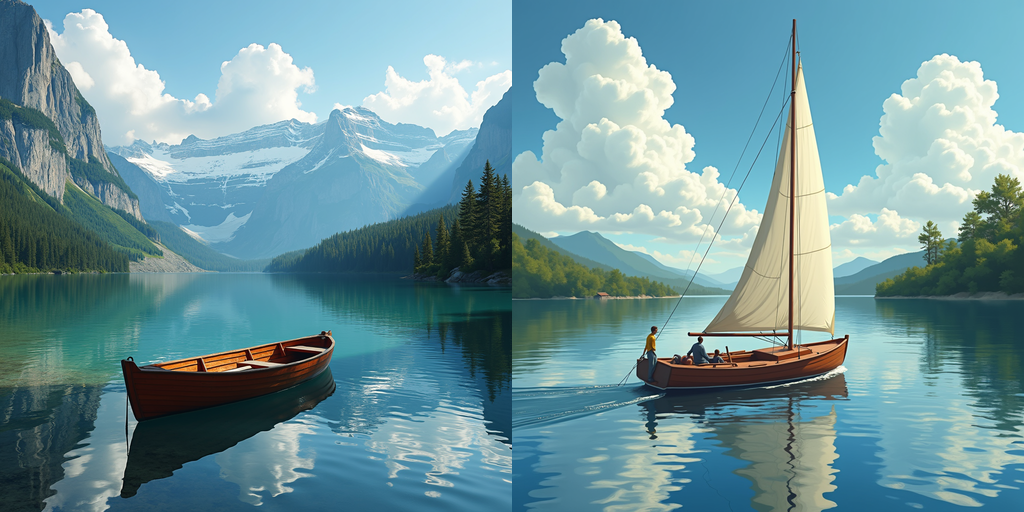

In [4]:
register_ori_attention(pipe)
image_ori_list = pipe(
    prompt,
    height=height,
    width=width,
    guidance_scale=3.5,
    num_inference_steps=50,
    max_sequence_length=512,
    latents=latents,
).images
display(resize_and_concat_images(image_ori_list))

In [5]:
register_reasoning_attention_control(pipe, **processor_args)
derive_idx_list = pipe(
    prompt,
    height=height,
    width=width,
    guidance_scale=3.5,
    num_inference_steps=50,
    max_sequence_length=512,
    latents=latents,
    subject_idx_list=subject_idx_list,
)


Reasoning at denoising steps:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Reasoning at U-Net layers:  [1, 2, 4, 26, 30, 54, 55]
Model FluxTransformer2DModel is registered attention processor: FluxAttnProcessor2_0_Reasoning


  0%|          | 0/50 [00:00<?, ?it/s]

/mnt/slurm_home/tywei/anaconda3/envs/freeflux/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Add object control at denoising steps:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Add object control at U-Net layers:  [1, 2, 4, 26, 30, 54, 55]
Model FluxTransformer2DModel is registered attention processor: FluxAttnProcessor2_0_Add_Object


  0%|          | 0/50 [00:00<?, ?it/s]

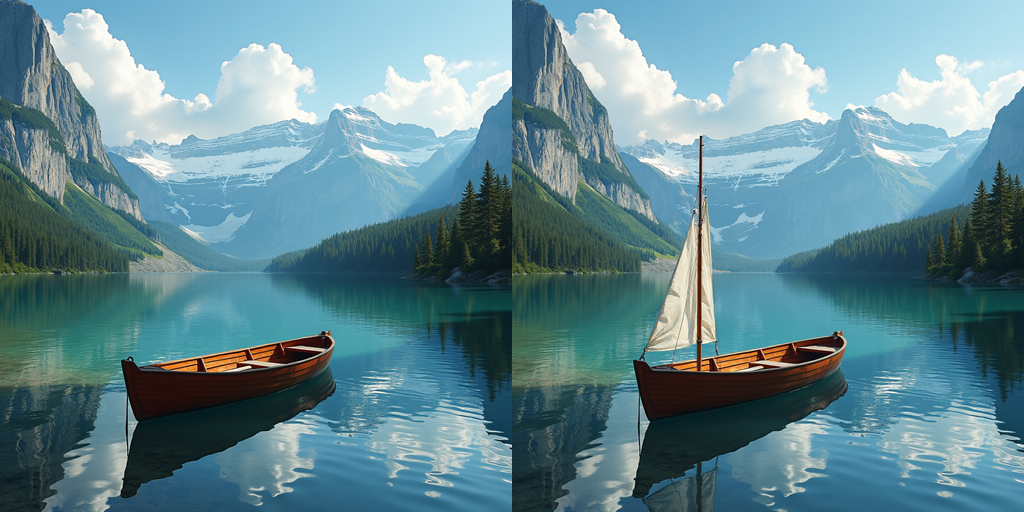

In [6]:
register_add_object_attention_control(pipe, **processor_args)
image_masa_list = pipe(
    prompt,
    height=height,
    width=width,
    guidance_scale=3.5,
    num_inference_steps=50,
    max_sequence_length=512,
    latents=latents,
    derive_idx_list=derive_idx_list,
).images
display(resize_and_concat_images(image_masa_list))

## Real Images Editing (Optional)

In [7]:
input_img_path = 'pexels-tatyana-doloman-728740365-30537431-2.jpg'
prompt_subject = [['A woman is sitting on the grass', 'A woman wearing a hat is sitting on the grass'], 'hat']#[[src_prompt, tar_prompt], added_word]
prompt = prompt_subject[0]
subject_idx_list = get_index_from_subject(pipe, prompt_subject[0][1], prompt_subject[1])


In [8]:
register_ori_attention(pipe)
inverted_latent_list = pipe(
    prompt[0],
    height=height,
    width=width,
    guidance_scale=1,
    num_inference_steps=50,
    max_sequence_length=512,
    latents=image2latent(pipe, Image.open(input_img_path), height//8, width//8),
    invert_image=True
)


Model FluxTransformer2DModel is registered attention processor: FluxAttnProcessor2_0


  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
register_reasoning_attention_control(pipe, **processor_args)
derive_idx_list = pipe(
    prompt,
    height=height,
    width=width,
    guidance_scale=[1]+[3.5],
    num_inference_steps=50,
    max_sequence_length=512,
    latents=inverted_latent_list[-1].tile(len(prompt), 1, 1),
    inverted_latent_list=inverted_latent_list,
    subject_idx_list=subject_idx_list,
)

Reasoning at denoising steps:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Reasoning at U-Net layers:  [1, 2, 4, 26, 30, 54, 55]
Model FluxTransformer2DModel is registered attention processor: FluxAttnProcessor2_0_Reasoning


  0%|          | 0/50 [00:00<?, ?it/s]

Add object control at denoising steps:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Add object control at U-Net layers:  [1, 2, 4, 26, 30, 54, 55]
Model FluxTransformer2DModel is registered attention processor: FluxAttnProcessor2_0_Add_Object


  0%|          | 0/50 [00:00<?, ?it/s]

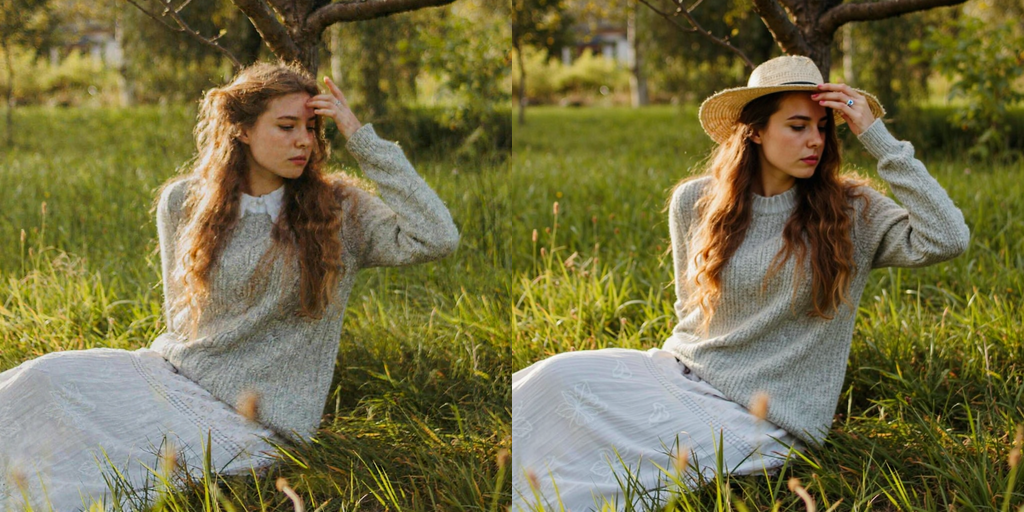

In [10]:
register_add_object_attention_control(pipe, **processor_args)
image_masa_list = pipe(
    prompt,
    height=height,
    width=width,
    guidance_scale=[1]+[3.5],
    num_inference_steps=50,
    max_sequence_length=512,
    latents=inverted_latent_list[-1].tile(len(prompt), 1, 1),
    inverted_latent_list=inverted_latent_list,
    derive_idx_list=derive_idx_list,
).images
display(resize_and_concat_images(image_masa_list))
